<a href="https://colab.research.google.com/github/jaswanth-adas/CGM_Project/blob/master/My_own_Latest_Roboflow_EfficientNet_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train EfficientNet to recognize custom classifications


Many, many props to DLogogy for publishing the orginal version of this tutorial. [How to do Transfer learning with EfficientNet](https://www.dlology.com/blog/transfer-learning-with-efficientnet/)

We use the same training infrastructure here with preprocessing, augmentations, and data import from Roboflow.

You only need to change one line of code for your dataset import to train this classification model.

You can scale the EfficientNet model up including:

* EfficientNet-B0
* EfficientNet-B1
* EfficientNet-B2
* EfficientNet-B3

Consider reading the [Original Paper](https://arxiv.org/pdf/1905.11946.pdf)

We recommend having the [Train EfficientNet Blog Post](https://blog.roboflow.ai/how-to-train-efficientnet/) up side by side to this notebook

<!-- #### ![Roboflow Workmark]
<!-- (https://i.imgur.com/WHFqYSJ.png) -->
<!-- (https://www.google.com/imgres?imgurl=https%3A%2F%2Fquotefancy.com%2Fmedia%2Fwallpaper%2F3840x2160%2F354028-George-Harrison-Quote-If-you-don-t-know-where-you-re-going-any.jpg&imgrefurl=https%3A%2F%2Fquotefancy.com%2Fquote%2F260%2FGeorge-Harrison-If-you-don-t-know-where-you-re-going-any-road-ll-take-you-there&tbnid=WAsYmgfwJ5Vh9M&vet=12ahUKEwiFwtH63-XsAhWuD7cAHe25C5AQMygDegUIARCoAQ..i&docid=v2Bm84-tvWTqWM&w=3840&h=2160&q=which%20road%20are%20you%20going&ved=2ahUKEwiFwtH63-XsAhWuD7cAHe25C5AQMygDegUIARCoAQ) --> -->

## Import EfficientNet Dependencies



In [1]:
# Downgrade pillow to avoid `UserWarning: Possibly corrupt EXIF data.`
#!pip install pillow==4.0.0

In [2]:
%tensorflow_version 1.x
#in case your keras version has bumped ahead you may want to try reverting to 2.3.1
#!pip install q keras==2.3.1

TensorFlow 1.x selected.


In [3]:
import keras
import os
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

## Clone **EfficinetNet** repo

Credit to [DLogogy](https://www.dlology.com/blog/transfer-learning-with-efficientnet/)

In [5]:

import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
  !git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


In [6]:
# More or less standard Python stuff
import datetime
import numpy
import os
import pandas
 
# Visualisation
%matplotlib inline
import matplotlib.pyplot as plt
 
# Machine learning
import sklearn
# to measure time taken to run the notebook
start_time = datetime.datetime.now()



## Import efficientnet and Choose EfficientNet Model

In [7]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.

#Choose
#EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [8]:
# loading pretrained conv base model

#define input height and width
width = 150
height = 150
input_shape = (height, width, 3)


conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


## Import Custom Dataset From Roboflow

To get your data into Roboflow, follow the [Getting Started Guide](https://blog.roboflow.ai/getting-started-with-roboflow/).

After loading your dataset in by dragging and dropping, you will only need to change one line of code with the curl link to train your own custom classification model.

Before upload, make sure that your data is in the structure

folder

---class1
    
------images
  
---class2

------images
  
  ...

In [9]:
!curl -L "https://app.roboflow.com/ds/crtc6bYGwa?key=Cg1OPfcdXt" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip  # my own custom road lane dataset link 300 images

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   889  100   889    0     0   1229      0 --:--:-- --:--:-- --:--:--  1227
100 4642k  100 4642k    0     0  5373k      0 --:--:-- --:--:-- --:--:-- 5373k
Archive:  roboflow.zip
replace README.roboflow.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.roboflow.txt     
 extracting: test/Center_of_road/frame3505_jpg.rf.8576f9506573159d0a4db4084b3b9e5b.jpg  
 extracting: test/Center_of_road/frame3513_jpg.rf.4c0e796c660a72a542b72bf49fd4b2f6.jpg  
 extracting: test/Center_of_road/frame3526_jpg.rf.418f164c9a5c1545984c08d89b1a45ab.jpg  
 extracting: test/Center_of_road/frame3530_jpg.rf.aa8476b4cf2b6f807c8231382084d6b2.jpg  
 extracting: test/Center_of_road/frame3552_jpg.rf.0fe8d1803b0ee5a77b559bc58ad3c0df.jpg  
 extracting: test/Center_of_road/frame3558_jpg.rf.c0fa602413f19e2efee88c95bc1c15c7.jpg  
 extracting: test/Ce

In [10]:
train_dir = '/content/efficientnet_keras_transfer_learning/train/'
valid_dir = '/content/efficientnet_keras_transfer_learning/valid/'
test_dir = '/content/efficientnet_keras_transfer_learning/test/'
batch_size = 4


import os
import random
def delete_all_but(split_path, number):
  images = []
  for path, subdirs, files in os.walk(split_path):
      for name in files:
          images.append(os.path.join(path, name))
  if len(images) > number:
    keep = random.sample(images, number)
    for img in images:
      if img not in keep:
        os.remove(img)
  return None


delete_all_but(train_dir, 25)
delete_all_but(valid_dir, 25)
delete_all_but(test_dir, 25)




In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to target height and width.
        target_size=(height, width),
        batch_size=batch_size,
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        valid_dir,
        target_size=(height, width),
        batch_size=batch_size,
        class_mode='categorical')
train_generator.class_indices

Found 25 images belonging to 3 classes.
Found 25 images belonging to 3 classes.


{'Center_of_road': 0, 'left_lane': 1, 'right_lane': 2}

# Set up EfficientNet Training Job

In [12]:
import os, os.path
epochs = 75
NUM_TRAIN = sum([len(files) for r, d, files in os.walk(train_dir)])
NUM_TEST = sum([len(files) for r, d, files in os.walk(valid_dir)])
dropout_rate = 0.2

In [13]:
num_classes = len(os.listdir(train_dir))
print('building netowrk for ' + str(num_classes) + ' classes')

model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(3, activation='softmax', name="fc_out"))

building netowrk for 3 classes


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 5, 5, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
dropout_out (Dropout)        (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 3)                 3843      
Total params: 4,053,407
Trainable params: 4,011,391
Non-trainable params: 42,016
_________________________________________________________________


In [15]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = True

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 213


# Run EfficientNet Training

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/75
6/6 [==============================] - 19s 3s/step - loss: 5.4070 - acc: 0.3810 - val_loss: 3.1334 - val_acc: 0.4167
Epoch 1/75
Epoch 2/75
6/6 [==============================] - 1s 198ms/step - loss: 4.0145 - acc: 0.3810 - val_loss: 3.1188 - val_acc: 0.3750
Epoch 3/75
6/6 [==============================] - 1s 201ms/step - loss: 2.1222 - acc: 0.5833 - val_loss: 2.7615 - val_acc: 0.4167
Epoch 4/75
6/6 [==============================] - 1s 201ms/step - loss: 2.8010 - acc: 0.4762 - val_loss: 2.9670 - val_acc: 0.3750
Epoch 5/75
6/6 [==============================] - 1s 218ms/step - loss: 2.0162 - acc: 0.8095 - val_loss: 2.9763 - val_acc: 0.3750
Epoch 6/75
6/6 [==============================] - 1s 230ms/step - loss: 1.3035 - acc: 0.5714 - val_loss: 2.7085 - val_acc: 0.4167
Epoch 7/75
6/6 [==============================] - 1s 197ms/step - loss: 0.9747 - acc: 0.7143 - val_loss: 2.8647 - val_acc: 0.3750
Epoch 8/75
6/6 [==============================] - 1s 144ms/step - loss: 0.6214 - 

# Examine EfficientNet Training Results

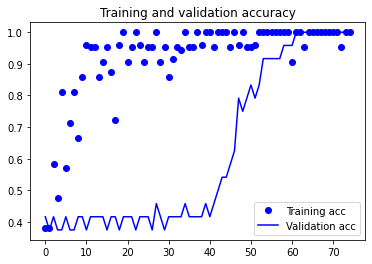

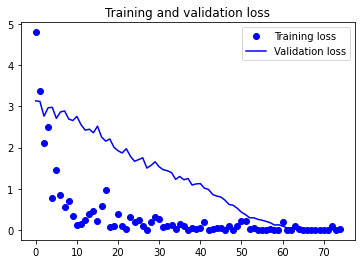

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine Tuning EfficientNet



In [18]:
# multiply_16
# set 'multiply_16' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'multiply_16':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= NUM_TEST // batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/75
6/6 [==============================] - 4s 716ms/step - loss: 0.0013 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2/75
6/6 [==============================] - 1s 162ms/step - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 3/75
6/6 [==============================] - 1s 155ms/step - loss: 1.9847e-04 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 4/75
6/6 [==============================] - 1s 162ms/step - loss: 3.6478e-05 - acc: 1.0000 - val_loss: 0.0039 - val_acc: 1.0000
Epoch 5/75
6/6 [==============================] - 1s 156ms/step - loss: 2.7627e-04 - acc: 1.0000 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 6/75
6/6 [==============================] - 1s 162ms/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000
Epoch 7/75
6/6 [==============================] - 1s 153ms/step - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000
Epoch 8/75
6/6 [==============================] - 1s 103ms/step - loss: 0.0035

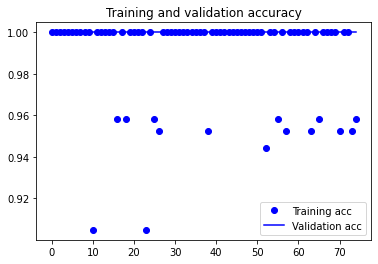

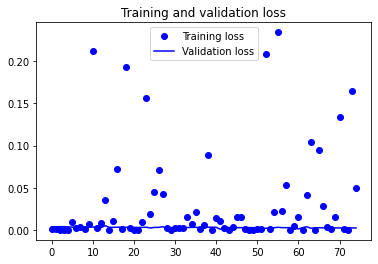

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Save EfficientNet Model Weights

In [33]:
os.makedirs("./models", exist_ok=True)
model.save('./models/efficientNet_latest1.h5')

# Use EfficientNet Trained Model for Inference



In [34]:
import random
test_dir = '/content/efficientnet_keras_transfer_learning/test/'
test_imgs = []
for path, subdirs, files in os.walk(test_dir):
    for name in files:
        test_imgs.append(os.path.join(path, name))
random_test_image = random.choice(test_imgs)
random_test_image

'/content/efficientnet_keras_transfer_learning/test/Center_of_road/frame3552_jpg.rf.0fe8d1803b0ee5a77b559bc58ad3c0df.jpg'

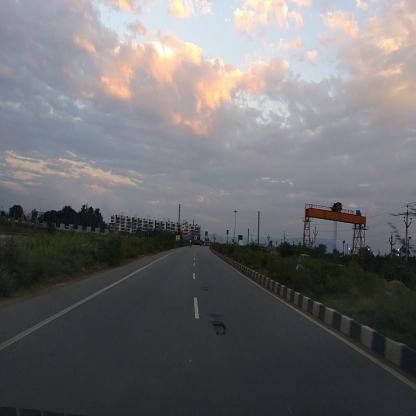

In [35]:
Image(filename=random_test_image)

In [36]:
from tensorflow.keras.preprocessing import image
import numpy as np

#recover class names from the train dataset generator
class_lookup = dict((y,x) for x,y in train_generator.class_indices.items())

def predict_image(img_path, class_lookup):
    # Read the image and resize it
    img = image.load_img(img_path, target_size=(height, width))
    # Convert it to a Numpy array with target shape.
    x = image.img_to_array(img)
    # Reshape
    x = x.reshape((1,) + x.shape)
    x /= 255.
    result = model.predict([x])[0][0]
    result_verbose = model.predict([x])
    if result > 0.5:
        animal = "cat"
    else:
        animal = "dog"
        result = 1 - result
    print(result_verbose)
    predicted_class = class_lookup[np.argmax(result_verbose, axis=1)[0]]
    predicted_probability = result_verbose[0][np.argmax(result_verbose, axis=1)[0]]

    return predicted_class ,predicted_probability, result_verbose

print(predict_image(random_test_image, class_lookup))

[[9.9998748e-01 1.0359487e-05 2.1129410e-06]]
('Center_of_road', 0.9999875, array([[9.9998748e-01, 1.0359487e-05, 2.1129410e-06]], dtype=float32))


In [37]:
# from keras.models import load_model
# # from keras_efficientnets import EfficientNetB0
# # from keras_efficientnet import custom_objects
# import cv2
# import numpy as np

# model = load_model('/content/efficientnet_keras_transfer_learning/models/efficientNet.h5')

# model.compile(loss='categorical_crossentropy',
#               optimizer='RMSprop',
#               metrics=['accuracy'])

# img = cv2.imread('frame3568_jpg.rf.5638ab44f0dc6df58abac5637dcef798.jpg')
# img = cv2.resize(img,(320,240))
# img = np.reshape(img,[1,320,240,3])

# classes = model.predict_classes(img)

# print(classes)

## Download Trained EfficientNet Model

In [38]:
from google.colab import files

files.download('./models/efficientNet_latest1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
model.input_shape

(None, 150, 150, 3)

## Load Trained EfficientNet Model

In [39]:
from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [40]:
from tensorflow.keras.models import load_model
model = load_model("./models/efficientNet_latest1.h5")

ValueError: ignored

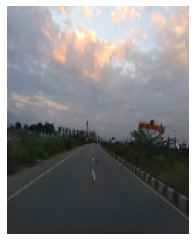

In [43]:
import numpy as np
test_dir = '/content/efficientnet_keras_transfer_learning/test/Center_of_road'
 
filenames_full = []
for dirpath, dirnames, filenames in os.walk(test_dir):
    for filename in filenames:
        filenames_full.append(os.path.join(dirpath, filename))
 
rows = (len(filenames_full) - 1) // 4 + 1
plt.figure(figsize=(15, 5 * rows))
for index, filename_full in enumerate(filenames_full):
    plt.subplot(rows, 4, index + 1)
    test_image = keras.preprocessing.image.load_img(filename_full, target_size=(160, 128))
    test_input = keras.preprocessing.image.img_to_array(test_image) * (1. / 255)
    test_input = numpy.expand_dims(test_input, axis=0)
    plt.imshow(test_image)
    plt.axis('off')
    prediction = model.predict(test_input)
    # np.resize(img, (-1, 150,150)
    color_name = decode_color_classes[numpy.argmax(prediction[0][0, :])]
    type_name = decode_type_classes[numpy.argmax(prediction[1][0, :])]
    plt.title(color_name + ' ' + type_name)

In [42]:
stop_time = datetime.datetime.now()
 
print('Executing the notebook took', (stop_time - start_time).total_seconds(), 'seconds')


Executing the notebook took 304.408392 seconds


In [46]:
!zip -r /content/efficientnet_keras_transfer_learning.zip /content/efficientnet_keras_transfer_learning

  adding: content/efficientnet_keras_transfer_learning/ (stored 0%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/ (stored 0%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/__version__.py (deflated 8%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/model.py (deflated 77%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/layers.py (deflated 64%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/params.py (deflated 71%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/__init__.py (deflated 43%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/__pycache__/ (stored 0%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/__pycache__/layers.cpython-36.pyc (deflated 46%)
  adding: content/efficientnet_keras_transfer_learning/efficientnet/__pycache__/__init__.cpython-36.pyc (deflated 26%)
  adding: content/efficientnet_keras_transfer_learni

In [47]:
from google.colab import files

files.download('/content/efficientnet_keras_transfer_learning.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>